In [ ]:
# Install required packages
!pip install opencv-contrib-python matplotlib numpy


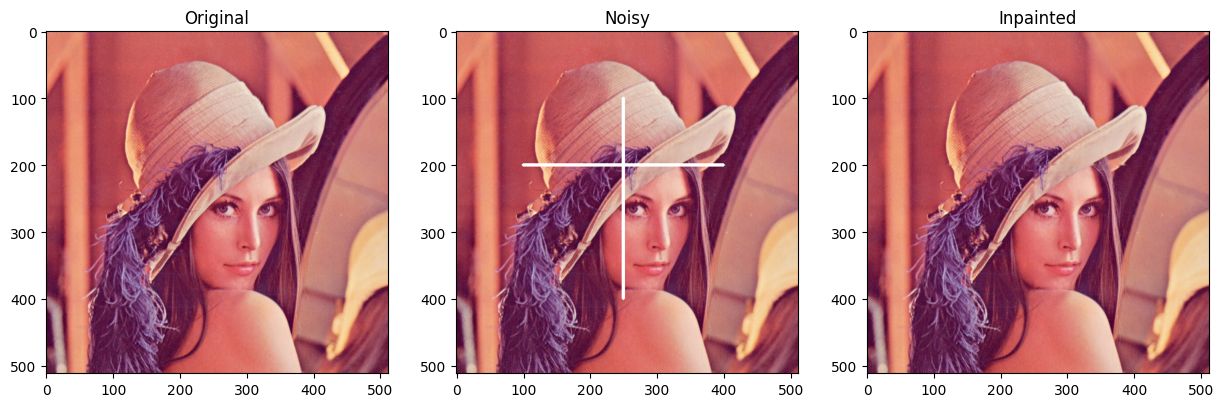

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

# Load image from URL
url = 'https://raw.githubusercontent.com/opencv/opencv/master/samples/data/lena.jpg'
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
image = cv2.resize(image, (512, 512))

# Add artificial noise
noisy_image = image.copy()
cv2.line(noisy_image, (100, 200), (400, 200), (255, 255, 255), 3)
cv2.line(noisy_image, (250, 100), (250, 400), (255, 255, 255), 3)

# Create a mask
mask = cv2.inRange(noisy_image, (250, 250, 250), (255, 255, 255))

# Inpaint using Telea algorithm
inpainted = cv2.inpaint(noisy_image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.title('Original'); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2); plt.title('Noisy'); plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3); plt.title('Inpainted'); plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))
plt.show()


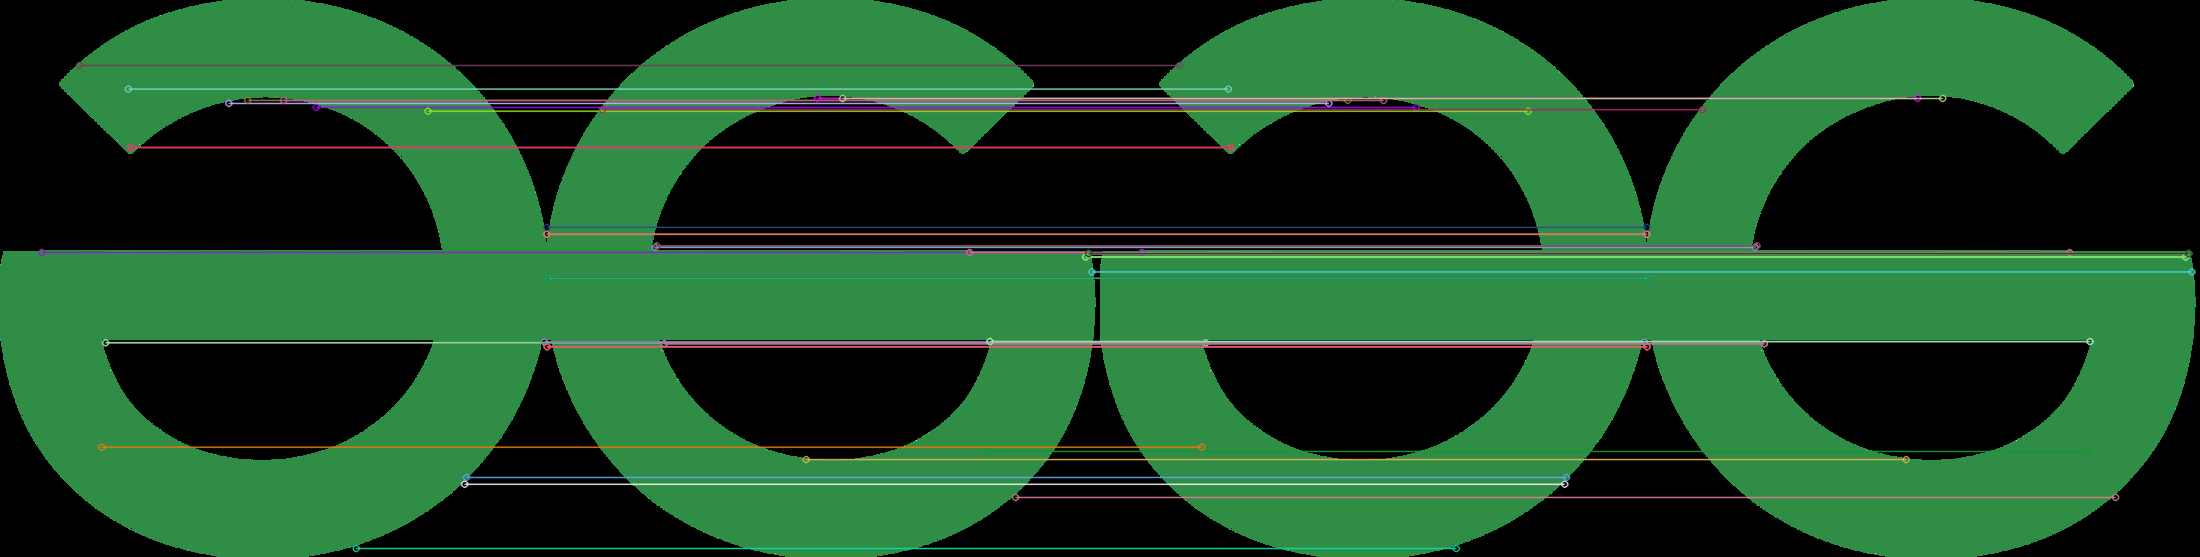

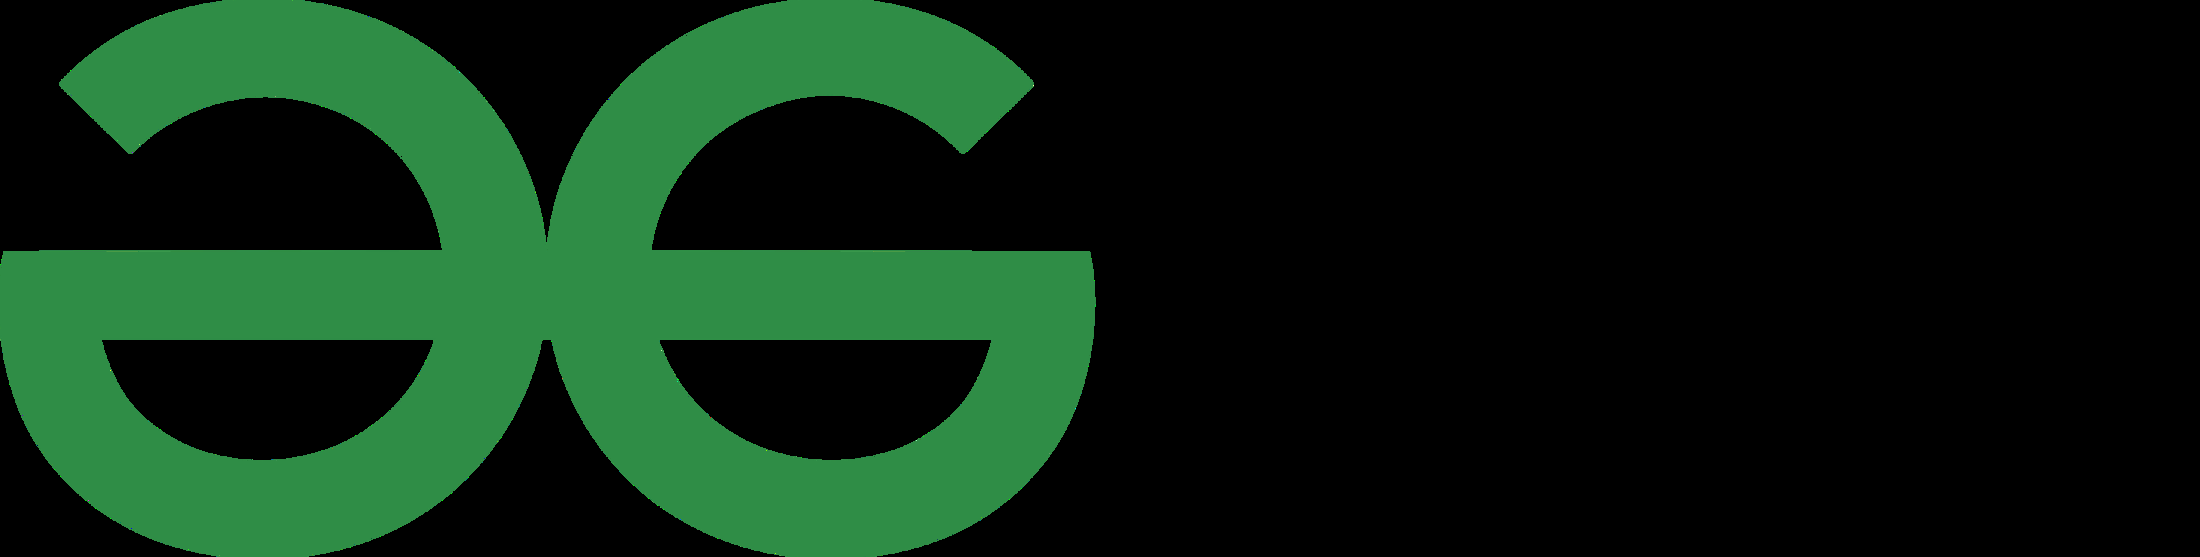

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Load images
img1 = cv2.imread('/content/img1.png')
img2 = cv2.imread('/content/img2.png')

# Ensure images loaded properly
if img1 is None or img2 is None:
    raise IOError("One or both images could not be loaded. Check the file paths.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Match descriptors using Brute Force matcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Visualize top 50 matches
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
cv2_imshow(img_matches)

# Extract matched keypoints
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute homography matrix
H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# Warp img2 to align with img1
h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]
result = cv2.warpPerspective(img2, H, (w1 + w2, max(h1, h2)))

# Overlay img1 on result
result[0:h1, 0:w1] = img1

# Show final stitched image
cv2_imshow(result)


📷 Input Image 1


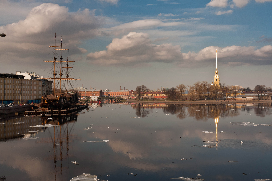

📷 Input Image 2


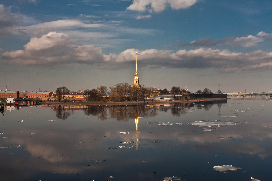

📷 Input Image 3


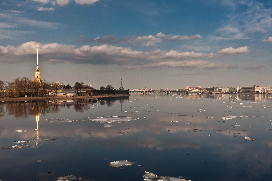

✅ Panorama created successfully!


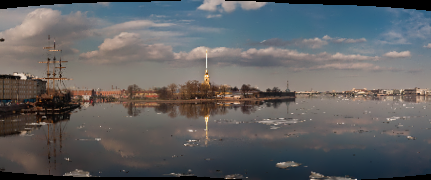

In [ ]:
import cv2
import urllib.request
from google.colab.patches import cv2_imshow

# ✅ URLs for panorama stitching
image_urls = [
    "https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/stitching/boat1.jpg",
    "https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/stitching/boat2.jpg",
    "https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/stitching/boat3.jpg"
]

# Step 1: Download images
image_paths = []
for i, url in enumerate(image_urls):
    filename = f"img{i+1}.jpg"
    urllib.request.urlretrieve(url, filename)
    image_paths.append(filename)

# Step 2: Load and resize images
imgs = []
for i, path in enumerate(image_paths):
    img = cv2.imread(path)
    img = cv2.resize(img, (0, 0), fx=0.07, fy=0.07)  # Resize to fit on screen
    imgs.append(img)

# Step 3: Show each input image
for i, img in enumerate(imgs):
    print(f"📷 Input Image {i+1}")
    cv2_imshow(img)

# Step 4: Stitch images into panorama
stitcher = cv2.Stitcher_create()
(status, result) = stitcher.stitch(imgs)

# Step 5: Show final panorama
if status != cv2.Stitcher_OK:
    print("❌ Stitching failed.")
else:
    print("✅ Panorama created successfully!")
    cv2_imshow(result)


Recovered Rotation:
 [[ 8.45121475e-01 -5.34564617e-01  3.21913152e-03]
 [ 5.34564444e-01  8.45127140e-01  9.86241348e-04]
 [-3.24778514e-03  8.87339507e-04  9.99994332e-01]]
Recovered Translation:
 [[ 0.93952032]
 [ 0.34248219]
 [-0.00274077]]


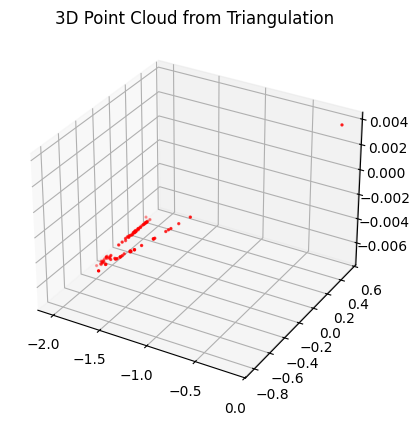

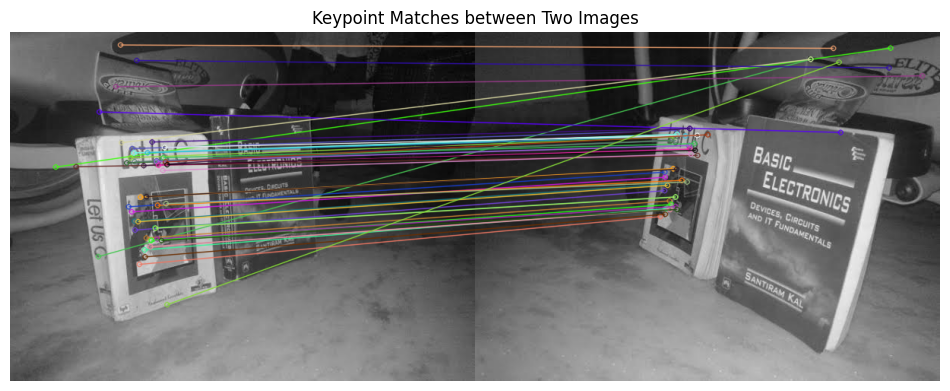

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load stereo image pair (replace with your own images)
img1 = cv2.imread("left.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("right.jpg", cv2.IMREAD_GRAYSCALE)

# Step 1: Detect keypoints and descriptors using SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Step 2: Match descriptors using BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Step 3: Apply ratio test
good = []
pts1 = []
pts2 = []

for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Step 4: Compute the Fundamental Matrix
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Step 5: Compute the Essential Matrix
# Assumes focal length = 1.0 and principal point at center (you should calibrate in real use)
focal = 1.0
pp = (img1.shape[1] / 2, img1.shape[0] / 2)
E, _ = cv2.findEssentialMat(pts1, pts2, focal=focal, pp=pp, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# Step 6: Recover the relative camera pose
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, focal=focal, pp=pp)

print("Recovered Rotation:\n", R)
print("Recovered Translation:\n", t)

# Step 7: Triangulation
# Projection matrix for the first camera: [I | 0]
proj1 = np.hstack((np.eye(3), np.zeros((3, 1))))
# Projection matrix for the second camera: [R | t]
proj2 = np.hstack((R, t))

# Convert points to homogeneous
pts1 = np.array(pts1, dtype=np.float32)  # Ensure float32 for undistortPoints
pts2 = np.array(pts2, dtype=np.float32)  # Ensure float32 for undistortPoints

# Ensure points are in a continuous format
pts1_hom = cv2.undistortPoints(np.expand_dims(pts1, axis=1), cameraMatrix=np.eye(3), distCoeffs=None)
pts2_hom = cv2.undistortPoints(np.expand_dims(pts2, axis=1), cameraMatrix=np.eye(3), distCoeffs=None)

# Triangulate points
points_4d_hom = cv2.triangulatePoints(proj1, proj2, pts1_hom, pts2_hom)
points_3d = points_4d_hom[:3] / points_4d_hom[3]

# Plot the 3D points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3d[0], points_3d[1], points_3d[2], s=2, c='red')
ax.set_title('3D Point Cloud from Triangulation')
plt.show()

# Step 8: Visualize the matching keypoints between the two images
# Draw the first 50 good matches
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matching keypoints
plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.title("Keypoint Matches between Two Images")
plt.axis('off')
plt.show()


Training MNIST GAN...
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - d_loss: 0.5502 - g_loss: 0.9551
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - d_loss: 0.6149 - g_loss: 0.9501
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - d_loss: 0.6198 - g_loss: 0.9601
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - d_loss: 0.6389 - g_loss: 0.9133
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - d_loss: 0.6423 - g_loss: 0.8583
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - d_loss: 0.6406 - g_loss: 0.8925
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - d_loss: 0.6335 - g_loss: 0.9292
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - d_loss: 0.6240 - g_loss: 0.9084
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - d_loss: 0.6195 - g_loss: 0.9162
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - d_loss: 0.6218 - g_loss: 0.9571
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - d_loss: 0.6203 - g_loss: 0.9379
Epoch 12

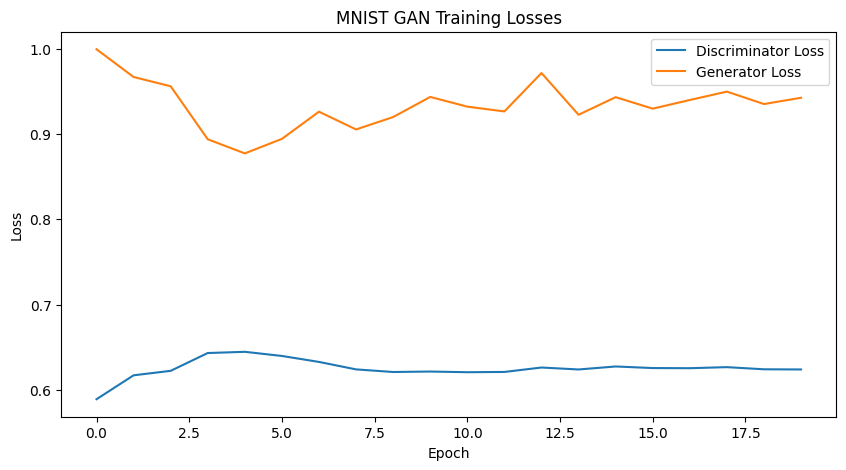

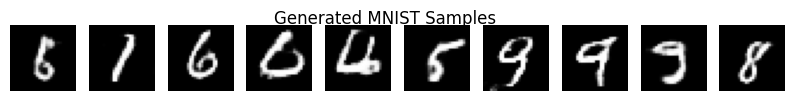

Training CIFAR-10 GAN...
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - d_loss: 0.5416 - g_loss: 1.0978
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - d_loss: 0.6109 - g_loss: 1.0713
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - d_loss: 0.6609 - g_loss: 0.9364
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - d_loss: 0.6854 - g_loss: 0.8477
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - d_loss: 0.6717 - g_loss: 0.8759
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - d_loss: 0.6635 - g_loss: 0.9167
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - d_loss: 0.6655 - g_loss: 0.8903
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - d_loss: 0.6687 - g_loss: 0.9124
Epoch 9/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - d_loss: 0.6658 - g_loss: 0.9556
Epoch 10/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - d_loss: 0.6571 - g_loss: 0.9555
Epoch 11/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - d_loss: 0.6646 - g_loss: 0.9562
Epoch

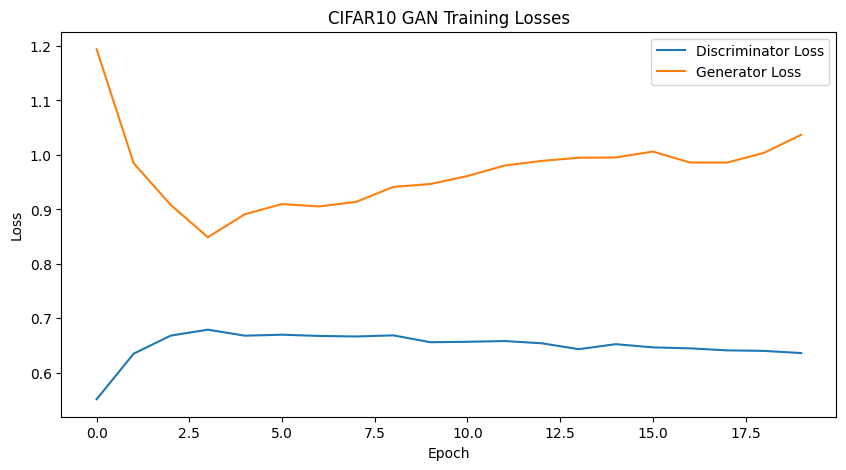

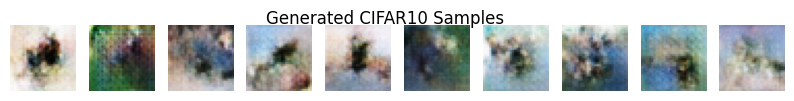

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist, cifar10

# Load datasets
(x_train_mnist, _), (_, _) = mnist.load_data()
(x_train_cifar, _), (_, _) = cifar10.load_data()

# Preprocess
def preprocess_data(x, dataset):
    x = x.astype('float32') / 255.
    if dataset == 'mnist':
        x = np.expand_dims(x, -1)
    return x

x_train_mnist = preprocess_data(x_train_mnist, 'mnist')
x_train_cifar = preprocess_data(x_train_cifar, 'cifar10')

# Generator
def build_generator(latent_dim, img_shape):
    model = keras.Sequential()
    if img_shape[0] == 28:
        model.add(layers.Input(shape=(latent_dim,)))
        model.add(layers.Dense(7 * 7 * 256, use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((7, 7, 256)))
        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    else:
        model.add(layers.Input(shape=(latent_dim,)))
        model.add(layers.Dense(8 * 8 * 256, use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((8, 8, 256)))
        model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Discriminator
def build_discriminator(img_shape):
    model = keras.Sequential()
    model.add(layers.Input(shape=img_shape))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# Custom GAN class
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Sample latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))  # label smoothing

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Train generator
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

# Training function
def train_gan(dataset, img_shape, latent_dim=128, epochs=20, batch_size=128):
    if dataset == 'mnist':
        (x_train, _), (_, _) = mnist.load_data()
        x_train = np.expand_dims(x_train, -1).astype('float32') / 255.
        x_train = x_train * 2 - 1
    else:
        (x_train, _), (_, _) = cifar10.load_data()
        x_train = x_train.astype('float32') / 255.
        x_train = x_train * 2 - 1

    train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000).batch(batch_size)

    generator = build_generator(latent_dim, img_shape)
    discriminator = build_discriminator(img_shape)

    gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
    gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )

    history = gan.fit(train_dataset, epochs=epochs)

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='Discriminator Loss')
    plt.plot(history.history['g_loss'], label='Generator Loss')
    plt.title(f'{dataset.upper()} GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Generate and plot samples
    latent_vectors = tf.random.normal(shape=(10, latent_dim))
    generated_images = generator(latent_vectors)
    generated_images = (generated_images + 1) / 2

    plt.figure(figsize=(10, 1))
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        if img_shape[-1] == 1:
            plt.imshow(generated_images[i].numpy().squeeze(), cmap='gray')
        else:
            plt.imshow(generated_images[i].numpy())
        plt.axis('off')
    plt.suptitle(f'Generated {dataset.upper()} Samples')
    plt.show()

    return generator, discriminator, history

# Train on MNIST
print("Training MNIST GAN...")
mnist_generator, mnist_discriminator, mnist_history = train_gan(
    'mnist', img_shape=(28, 28, 1), epochs=20
)

# Train on CIFAR-10
print("Training CIFAR-10 GAN...")
cifar_generator, cifar_discriminator, cifar_history = train_gan(
    'cifar10', img_shape=(32, 32, 3), epochs=20
)
